# readme
descrip: plot Vvel (rotated to N-S direction) cross-section (30N) trends from 2001-2100  <br>

update history: <br>
v1.0 DL 2021Oct10 <br>
 
extra notes: <br>

# import modules

In [1]:
# general python packages
import numpy as np
from scipy import stats
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
%matplotlib inline
import proplot as plot
import cartopy
import cartopy.crs as ccrs
cartopy.config['pre_existing_data_dir']='/ihesp/shared/cartopy_features'
# from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# from mpl_toolkits.axes_grid1 import AxesGrid
import glob

# python GCM(POP) packages
# import xgcm
import pop_tools
import xoak
# import xesmf as xe

# dask jupyter lab packages
from dask.distributed import Client
# from dask.distributed import performance_report

# file name with time packages
# from itertools import product
# from cftime import DatetimeNoLeap

# incorporate dask 

In [2]:
client = Client("tcp://10.73.3.175:40063")
client

<Client: 'tcp://10.73.3.175:40063' processes=16 threads=16, memory=316.64 GiB>

# define parameters

In [3]:
time2 = np.arange(2001,2100+1,1)

# === r: region (US east coast excluding Gulf of Mexico) ===
# reference: Plot2FindGulfMexicoYucatanChannelFLstraitnlatnlonIndex_2021Jul20.ipynb
nlon1_r_t12, nlon2_r_t12 = 200+50, 700-50 
nlat1_r_t12, nlat2_r_t12 = 1300+100, 2000-100

nlon1_r_g16, nlon2_r_g16 = 260, 321
nlat1_r_g16, nlat2_r_g16 = 230, 350


lon1_r, lon2_r = -85, -50
lat1_r, lat2_r = 25, 55
# ===========================================================

# sec1: cross-shore section at 30 deg N at southeast US coast

chunks_HR = {'nlat':400,'nlon':300}
chunks_LR = {'nlat':384,'nlon':320}

# --- 30N ---
# lat1_sec1 = 30
# lon1_sec1, lon2_sec1 = -82+360, -74+360

# ilat1_t12 = 1497
# ilon1_t12, ilon2_t12 = 270, 360

# ilat1_g16 = 279
# ilon1_g16, ilon2_g16 = 279, 292
# -----------

# --- 26.5 N ---
# lat1_sec1 = 26.5
# lon1_sec1, lon2_sec1 = -82+360, -74+360

# ilat1_t12 = 1456
# ilon1_t12, ilon2_t12 = 270, 360

# ilat1_g16 = 270
# ilon1_g16, ilon2_g16 = 279, 292
# --------------

# --- 28 N ---
lat1_sec1 = 26.5
lon1_sec1, lon2_sec1 = -82+360, -74+360 # pop tools xoak uses TLONG (0-360) for the closest points

ilat1_t12 = 1473
ilon1_t12, ilon2_t12 = 280, 360

ilat1_g16 = 274
ilon1_g16, ilon2_g16 = 281, 290
# --------------

# # --- 35N ---
# lat1_sec1 = 35
# lon1_sec1, lon2_sec1 = -76+360, -68+360 # TLONG is 0-360

# ilat1_t12 = 1558 #1562
# ilon1_t12, ilon2_t12 = 320, 420

# ilat1_g16 = 290-1
# ilon1_g16, ilon2_g16 = 287-2, 295
# # ------------

# read files

In [4]:
# read TH U, V vel

# 'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.TEMP.192801-192812.nc'
yrs1a_TH = np.arange(2001,2005+1) 
prefix1a_TH = 'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.'

indir1a_uvel_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/proc/tseries/month_1/UVEL/')
infiles1a_uvel_TH = [indir1a_uvel_TH + prefix1a_TH + 'UVEL.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs1a_TH]
infiles1a_uvel_TH

indir1a_vvel_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/proc/tseries/month_1/VVEL/')
infiles1a_vvel_TH = [indir1a_vvel_TH + prefix1a_TH + 'VVEL.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs1a_TH]
infiles1a_vvel_TH


yrs2_TH = np.arange(2006,2100+1)
prefix2_TH = 'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.'
indir1b_uvel_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/UVEL/')
infiles2_uvel_TH = [indir1b_uvel_TH + prefix2_TH + 'UVEL.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs2_TH]
infiles2_uvel_TH

indir1b_vvel_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/VVEL/')
infiles2_vvel_TH = [indir1b_vvel_TH + prefix2_TH + 'VVEL.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs2_TH]
infiles2_vvel_TH


ds_uvel_TH = xr.open_mfdataset(infiles1a_uvel_TH + infiles2_uvel_TH, compat="override", combine="by_coords", 
                       data_vars="minimal", coords="minimal", chunks=chunks_HR, 
                       parallel=True)

ds_vvel_TH = xr.open_mfdataset(infiles1a_vvel_TH + infiles2_vvel_TH, compat="override", combine="by_coords", 
                       data_vars="minimal", coords="minimal", chunks=chunks_HR, 
                       parallel=True)
ds_vvel_TH 

<xarray.Dataset>
Dimensions:             (d2: 2, nlat: 2400, nlon: 3600, time: 1200, z_t: 62, z_t_150m: 15, z_w: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
  * z_t                 (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
  * z_t_150m            (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                 (z_w) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_top             (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot             (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
    ULONG               (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    ULAT                (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    TLONG               (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    TLAT                (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
  * time                (time) object 2001-02-01 00:00:00 ... 2101-01-01 00:0...
Dimensions without coordinates: d2, nlat, nlon
Data variables: (12/51)
    dz                  (z_t) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    dzw                 (z_w) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    KMT                 (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    KMU                 (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    REGION_MASK         (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    UAREA               (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    ...                  ...
    salinity_factor     float64 ...
    sflux_factor        float64 ...
    nsurface_t          float64 ...
    nsurface_u          float64 ...
    time_bound          (time, d2) object dask.array<chunksize=(12, 2), meta=np.ndarray>
    VVEL                (time, z_t, nlat, nlon) float32 dask.array<chunksize=(12, 62, 400, 300), meta=np.ndarray>
Attributes:
    title:         B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway
    history:       Thu Aug 26 14:23:01 2021: ncap2 -A -s time=udunits(time, "...
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-03-16 at 08:33:13.4
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  34411091
    tavg_sum:      2678400.0
    NCO:           netCDF Operators version 4.8.1 (Homepage = http://nco.sf.n...

In [5]:
# read CH U, V vel

# 'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.TEMP.192801-192812.nc'
yrs1a_CH = np.arange(401,500+1) 
prefix1a_CH = 'B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.'

indir1a_uvel_CH = ('/ihesp/archive/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02/ocn/proc/UVEL/')
infiles1a_uvel_CH = [indir1a_uvel_CH + prefix1a_CH + 'UVEL.' + str(iyr).zfill(4) +'01-' + str(iyr).zfill(4)+ '12.nc'
                     for iyr in yrs1a_CH]
infiles1a_uvel_CH

indir1a_vvel_CH = ('/ihesp/archive/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02/ocn/proc/VVEL/')
infiles1a_vvel_CH = [indir1a_vvel_CH + prefix1a_CH + 'VVEL.' + str(iyr).zfill(4) +'01-' + str(iyr).zfill(4)+ '12.nc'
               for iyr in yrs1a_CH]
infiles1a_vvel_CH

ds_uvel_CH = xr.open_mfdataset(infiles1a_uvel_CH, compat="override", combine="by_coords", 
                       data_vars="minimal", coords="minimal", chunks=chunks_HR, 
                       parallel=True)

ds_vvel_CH = xr.open_mfdataset(infiles1a_vvel_CH, compat="override", combine="by_coords", 
                       data_vars="minimal", coords="minimal", chunks=chunks_HR, 
                       parallel=True)
ds_vvel_CH 

<xarray.Dataset>
Dimensions:             (d2: 2, nlat: 2400, nlon: 3600, time: 1200, z_t: 62, z_t_150m: 15, z_w: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
  * z_t                 (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
  * z_t_150m            (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                 (z_w) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_top             (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot             (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
    ULONG               (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    ULAT                (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    TLONG               (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    TLAT                (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
  * time                (time) object 0401-02-01 00:00:00 ... 0501-01-01 00:0...
Dimensions without coordinates: d2, nlat, nlon
Data variables: (12/51)
    dz                  (z_t) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    dzw                 (z_w) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    KMT                 (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    KMU                 (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    REGION_MASK         (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    UAREA               (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    ...                  ...
    salinity_factor     float64 ...
    sflux_factor        float64 ...
    nsurface_t          float64 ...
    nsurface_u          float64 ...
    time_bound          (time, d2) object dask.array<chunksize=(12, 2), meta=np.ndarray>
    VVEL                (time, z_t, nlat, nlon) float32 dask.array<chunksize=(12, 62, 400, 300), meta=np.ndarray>
Attributes:
    title:         B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02
    history:       Sat Jul 24 15:04:58 2021: ncap2 -A -s time=udunits(time, "...
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-01-03 at 01:54:07.7
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  86568131
    tavg_sum:      2678400.0
    NCO:           netCDF Operators version 4.8.1 (Homepage = http://nco.sf.n...

In [6]:
# read U, V TL
infile1_uvel_TL = ('/ihesp/archive/B.E.13.BHISTC5.ne30g16.sehires38.003.sunway/tseries/ocn/to_archive/'
                   'B.E.13.BHISTC5.ne30g16.sehires38.003.sunway.pop.h.UVEL.185001-200512.nc')
infile1_vvel_TL = ('/ihesp/archive/B.E.13.BHISTC5.ne30g16.sehires38.003.sunway/tseries/ocn/to_archive/'
                   'B.E.13.BHISTC5.ne30g16.sehires38.003.sunway.pop.h.VVEL.185001-200512.nc')

infile2_uvel_TL = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne30g16.sehires38.003.sunway.CN_OFF/tseries/ocn/to_archive/'
                   'B.E.13.BRCP85C5CN.ne30g16.sehires38.003.sunway.CN_OFF.pop.h.UVEL.200601-210512.nc')
infile2_vvel_TL = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne30g16.sehires38.003.sunway.CN_OFF/tseries/ocn/to_archive/'
                   'B.E.13.BRCP85C5CN.ne30g16.sehires38.003.sunway.CN_OFF.pop.h.VVEL.200601-210512.nc')

ds_uvel_TL_raw = xr.open_mfdataset([infile1_uvel_TL, infile2_uvel_TL], compat="override", combine="by_coords", 
                       data_vars="minimal", coords="minimal", chunks=chunks_LR, parallel=True)

ds_vvel_TL_raw = xr.open_mfdataset([infile1_vvel_TL, infile2_vvel_TL], compat="override", combine="by_coords", 
                       data_vars="minimal", coords="minimal", chunks=chunks_LR, parallel=True)

# === 2022Jan10 directly selecting time (codes below) returns errors due to different calendar types === 
# ds_uvel_TL = ds_uvel_TL_raw.sel(time=slice('2001-01','2101-01'))
# TypeError: cannot compare cftime.datetime(1978, 1, 1, 0, 0, 0, 0, calendar='noleap', has_year_zero=True) and 
#     cftime.datetime(2001, 1, 1, 0, 0, 0, 0, calendar='gregorian', has_year_zero=False)
# ========================================================================================

# 2001-1850=151 yr, 2100-2001+1=100 yr
time_vvel_s_TL = ds_vvel_TL_raw.time.to_pandas().index.shift(-1,'D') # shift it one month back 
ds_uvel_TL = ds_uvel_TL_raw.assign_coords(time=time_vvel_s_TL).sel(time=slice('2001','2100'))
ds_vvel_TL = ds_vvel_TL_raw.assign_coords(time=time_vvel_s_TL).sel(time=slice('2001','2100'))

print('ds_vvel_TL first time: ', ds_vvel_TL.time[0].values)
print('ds_vvel_TL end time: ', ds_vvel_TL.time[-1].values)
print('ds_vvel_TL # time: ', len(ds_vvel_TL.time)) # miss 2014-Jan (2014-02-01 monthly file) from vvel data file

# ds_uvel_TL

ds_vvel_TL first time:  2001-01-31 00:00:00
ds_vvel_TL end time:  2100-12-31 00:00:00
ds_vvel_TL # time:  1199


In [7]:
# # read TL U, V vel
# indir1_TL = ('/ihesp/archive/'
#           'B.E.13.BHISTC5.ne30g16.sehires38.003.sunway/ocn/monthly/')
# infiles1_TL = sorted(glob.glob(indir1_TL+'cmpr_B.E.13.BHISTC5.ne30g16.sehires38.003.sunway.pop.h.200[1-5]-??.nc'))

# indir2_TL = ('/ihesp/archive/'
#           'B.E.13.BRCP85C5CN.ne30g16.sehires38.003.sunway.CN_OFF/ocn/monthly/')
# infiles2a_TL = sorted(glob.glob(indir2_TL+'cmpr_B.E.13.BRCP85C5CN.ne30g16.sehires38.003.sunway.CN_OFF.pop.h.20??-??.nc'))

# infiles2b_TL = sorted(glob.glob(indir2_TL+'cmpr_B.E.13.BRCP85C5CN.ne30g16.sehires38.003.sunway.CN_OFF.pop.h.2100-??.nc')) # add year 2100, 
# infiles_TL = infiles1_TL + infiles2a_TL + infiles2b_TL
# print(infiles_TL[0])
# print(infiles_TL[-1])

# ds0_TL=xr.open_dataset(infiles2a_TL[0])

# keeplist=['VVEL','UVEL','time','z_t','ULONG','ULAT']

# droplist_TL=list(ds0_TL.variables)
# for i in keeplist:
#     droplist_TL.remove(i)
# # droplist
# droplist_TL = droplist_TL + ['CFC_IFRAC','CFC_XKW','CFC_ATM_PRESS','CFC11','STF_CFC11','CFC12','STF_CFC12']
# # HIST and RCP85 have different outputs, add more variables to droplist
# print(droplist_TL)

# ds_TL = xr.open_mfdataset(infiles_TL, compat="override", combine="by_coords", 
#                        data_vars="minimal", coords="minimal", chunks=chunks_LR, 
#                        drop_variables=droplist_TL, parallel=True)
# ds_TL

In [8]:
# # read CL U, V  vel
# indir_CL = ('/ihesp/archive/'
#           'B.E.13.B1850C5.ne30g16.sehires38.003.sunway/ocn/monthly/')
# infiles1a_CL = sorted(glob.glob(indir_CL+'cmpr_B.E.13.B1850C5.ne30g16.sehires38.003.sunway.pop.h.04??-??.nc'))
# del infiles1a_CL[0:11+1] # remove year 400

# infiles1b_CL = sorted(glob.glob(indir_CL+'cmpr_B.E.13.B1850C5.ne30g16.sehires38.003.sunway.pop.h.0500-??.nc')) # add year 500, 
# infiles_CL = infiles1a_CL + infiles1b_CL
# print(infiles_CL[0])
# print(infiles_CL[-1])

# ds0_CL=xr.open_dataset(infiles_CL[0])

# keeplist=['VVEL','UVEL','time','z_t','ULONG','ULAT']

# droplist_CL=list(ds0_CL.variables)
# for i in keeplist:
#     droplist_CL.remove(i)
# # droplist

# ds_CL = xr.open_mfdataset(infiles_CL, compat="override", combine="by_coords", 
#                        data_vars="minimal", coords="minimal", chunks=chunks_LR, 
#                        drop_variables=droplist_CL, parallel=True)
# ds_CL
# read U, V CL
infile_uvel_CL = ('/ihesp/archive/B.E.13.B1850C5.ne30g16.sehires38.003.sunway/tseries/ocn/to_archive/'
                  'B.E.13.B1850C5.ne30g16.sehires38.003.sunway.pop.h.UVEL.25001-50112.nc')
infile_vvel_CL = ('/ihesp/archive/B.E.13.B1850C5.ne30g16.sehires38.003.sunway/tseries/ocn/to_archive/'
                  'B.E.13.B1850C5.ne30g16.sehires38.003.sunway.pop.h.VVEL.25001-50112.nc')
ds_uvel_CL_raw = xr.open_dataset(infile_uvel_CL, chunks=chunks_LR)
ds_vvel_CL_raw = xr.open_dataset(infile_vvel_CL, chunks=chunks_LR)
ds_uvel_CL = ds_uvel_CL_raw.sel(time=slice('0401-02','0501-01'))
ds_vvel_CL = ds_vvel_CL_raw.sel(time=slice('0401-02','0501-01'))

print('ds_vvel_CL first time: ', ds_vvel_CL.time[0].values)
print('ds_vvel_CL end time: ', ds_vvel_CL.time[-1].values)
print('ds_vvel_CL # time: ', len(ds_vvel_CL.time)) 
# miss 0417-02, 0445-06, 0401-11 three monthly data files
# ds_vvel_CL

ds_vvel_CL first time:  0401-02-01 00:00:00
ds_vvel_CL end time:  0501-01-01 00:00:00
ds_vvel_CL # time:  1197


In [9]:
# supplimentary files 
# infile0_LR = ('/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/'
#               'cmpr_B.E.13.BHISTC5.ne30g16.sehires38.003.sunway.pop.h.1850-01.nc')
# ds0_LR = xr.open_dataset(infile0_LR)
# ds0_LR

# infile0_HR = ('/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/'
#               'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.1850-01.nc')
# ds0_HR = xr.open_dataset(infile0_HR)
# ds0_HR

infile_t12 = ('/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/POP_grids_2021Nov01/'
              'POPgrids_tx0.1v2_2020Jun29.nc') # POP t12 grid file
ds_t12 = xr.open_dataset(infile_t12)
ds_t12

infile_g16 = ('/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/POP_grids_2021Nov01/'
              'POPgrids_gx1v6_2020Jun29.nc') # POP g16 grid file
ds_g16 = xr.open_dataset(infile_g16)
ds_g16

ds_r_t12 = ds_t12.isel(nlon=slice(nlon1_r_t12, nlon2_r_t12), 
                       nlat=slice(nlat1_r_t12, nlat2_r_t12))
ds_r_g16 = ds_g16.isel(nlon=slice(nlon1_r_g16, nlon2_r_g16), 
                       nlat=slice(nlat1_r_g16, nlat2_r_g16))

In [10]:
# read moc TL
infile_MOC_TL = ('/ihesp/archive/Sunway_Runs/LR_HF_TNST/'
                 'B.E.13.BTRANS.ne30g16.sehires38.003.sunway.pop.h.MOC.185001.210012.nc')
ds_MOC_TL_raw = xr.open_dataset(infile_MOC_TL) # , chunks={'moc_z':1}
time_s_TL = ds_MOC_TL_raw.time.to_pandas().index.shift(-1,'D')
ds_MOC_TL = ds_MOC_TL_raw.assign_coords(time=time_s_TL).sel(time=slice('1850','2100'))
print('ds_MOC_TL.time[0]', ds_MOC_TL.time[0].values)
print('ds_MOC_TL.time[-1]', ds_MOC_TL.time[-1].values)
print('len(ds_MOC_TL.time)', len(ds_MOC_TL.time))
ds_MOC_TL

ds_MOC_TL.time[0] 1850-01-31 00:00:00
ds_MOC_TL.time[-1] 2100-12-31 00:00:00
len(ds_MOC_TL.time) 3012


<xarray.Dataset>
Dimensions:         (d2: 2, lat_aux_grid: 395, moc_comp: 3, moc_z: 61, time: 3012, transport_reg: 2)
Coordinates:
  * time            (time) object 1850-01-31 00:00:00 ... 2100-12-31 00:00:00
  * lat_aux_grid    (lat_aux_grid) float32 -79.49 -78.95 -78.42 ... 89.47 90.0
  * moc_z           (moc_z) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05 5.5e+05
Dimensions without coordinates: d2, moc_comp, transport_reg
Data variables:
    time_bound      (time, d2) object ...
    moc_components  (moc_comp) |S256 ...
    MOC             (time, transport_reg, moc_comp, moc_z, lat_aux_grid) float32 ...
Attributes:
    title:         B.E.13.BHISTC5.ne30g16.sehires38.003.sunway
    history:       none
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-04-11 at 22:22:40.9
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  750
    tavg_sum:      2592000.0

In [11]:
# read moc CL
infile_MOC_CL = ('/ihesp/archive/Sunway_Runs/LR_PI_CTRL/'
                 'B.E.13.B1850C5.ne30g16.sehires38.003.sunway.pop.h.MOC.000101.050012.nc')
ds_MOC_CL_raw = xr.open_dataset(infile_MOC_CL) # , chunks={'moc_z':1}
time_s_CL = ds_MOC_CL_raw.time.to_pandas().index.shift(-1,'D')
ds_MOC_CL = ds_MOC_CL_raw.assign_coords(time=time_s_CL).sel(time=slice('0250','0500'))
print('ds_MOC_CL.time[0]', ds_MOC_CL.time[0].values)
print('ds_MOC_CL.time[-1]', ds_MOC_CL.time[-1].values)
print('len(ds_MOC_CL.time)', len(ds_MOC_CL.time))
ds_MOC_CL

ds_MOC_CL.time[0] 0250-01-31 00:00:00
ds_MOC_CL.time[-1] 0500-12-31 00:00:00
len(ds_MOC_CL.time) 3012


<xarray.Dataset>
Dimensions:         (d2: 2, lat_aux_grid: 395, moc_comp: 3, moc_z: 61, nchar: 256, time: 3012, transport_reg: 2)
Coordinates:
  * time            (time) object 0250-01-31 00:00:00 ... 0500-12-31 00:00:00
  * lat_aux_grid    (lat_aux_grid) float32 -79.49 -78.95 -78.42 ... 89.47 90.0
  * moc_z           (moc_z) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05 5.5e+05
Dimensions without coordinates: d2, moc_comp, nchar, transport_reg
Data variables:
    time_bound      (time, d2) object ...
    moc_components  (moc_comp, nchar) |S1 ...
    MOC             (time, transport_reg, moc_comp, moc_z, lat_aux_grid) float32 ...
Attributes:
    title:           B.E.13.B1850C5.ne30g16.sehires38.003.sunway
    history:         none
    Conventions:     CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curr...
    contents:        Diagnostic and Prognostic Variables
    source:          CCSM POP2, the CCSM Ocean Component
    revision:        $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:        All years have exactly  365 days.
    start_time:      This dataset was created on 2020-03-12 at 12:53:17.5
    cell_methods:    cell_methods = time: mean ==> the variable values are av...
    nsteps_total:    750
    tavg_sum:        2592000.0
    tavg_sum_qflux:  2592000.0

In [12]:
# read moc TH
infile_MOC_TH = ('/ihesp/archive/Sunway_Runs/HR_HF_TNST/'
                 'B.E.13.BTRANS.ne120_t12.sehires38.003.sunway.pop.h.MOC.185001.210012.nc')
ds_MOC_TH_raw = xr.open_dataset(infile_MOC_TH) # , chunks={'moc_z':1}
time_s_TH = ds_MOC_TH_raw.time.to_pandas().index.shift(-1,'D')
ds_MOC_TH = ds_MOC_TH_raw.assign_coords(time=time_s_TH).sel(time=slice('1850','2100'))
print('ds_MOC_TH.time[0]', ds_MOC_TH.time[0].values)
print('ds_MOC_TH.time[-1]', ds_MOC_TH.time[-1].values)
print('len(ds_MOC_TH.time)', len(ds_MOC_TH.time))
ds_MOC_TH

ds_MOC_TH.time[0] 1850-01-31 00:00:00
ds_MOC_TH.time[-1] 2100-12-31 00:00:00
len(ds_MOC_TH.time) 3012


<xarray.Dataset>
Dimensions:            (lat_aux_grid: 395, moc_comp: 1, moc_z: 63, time: 3012, transport_reg: 2)
Coordinates:
  * time               (time) object 1850-01-31 00:00:00 ... 2100-12-31 00:00:00
    transport_regions  (transport_reg) |S256 ...
    moc_components     (moc_comp) |S256 ...
  * moc_z              (moc_z) float32 0.0 1e+03 2e+03 ... 5.75e+05 6e+05
  * lat_aux_grid       (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
Dimensions without coordinates: moc_comp, transport_reg
Data variables:
    MOC                (time, transport_reg, moc_comp, moc_z, lat_aux_grid) float32 ...

In [13]:
# read moc CH
infile_MOC_CH = ('/ihesp/archive/Sunway_Runs/HR_PI_CTRL/'
                 'B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.MOC.002101.050112.nc')
ds_MOC_CH_raw = xr.open_dataset(infile_MOC_CH) # , chunks={'moc_z':1}
time_s_CH = ds_MOC_CH_raw.time.to_pandas().index.shift(-1,'D')
ds_MOC_CH = ds_MOC_CH_raw.assign_coords(time=time_s_CH).sel(time=slice('0250','0500'))
print('ds_MOC_CH.time[0]', ds_MOC_CH.time[0].values)
print('ds_MOC_CH.time[-1]', ds_MOC_CH.time[-1].values)
print('len(ds_MOC_CH.time)', len(ds_MOC_CH.time))
ds_MOC_CH

ds_MOC_CH.time[0] 0250-01-31 00:00:00
ds_MOC_CH.time[-1] 0500-12-31 00:00:00
len(ds_MOC_CH.time) 3012


<xarray.Dataset>
Dimensions:            (lat_aux_grid: 395, moc_comp: 1, moc_z: 63, time: 3012, transport_reg: 2)
Coordinates:
  * time               (time) object 0250-01-31 00:00:00 ... 0500-12-31 00:00:00
    transport_regions  (transport_reg) |S256 ...
    moc_components     (moc_comp) |S256 ...
  * moc_z              (moc_z) float32 0.0 1e+03 2e+03 ... 5.75e+05 6e+05
  * lat_aux_grid       (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
Dimensions without coordinates: moc_comp, transport_reg
Data variables:
    MOC                (time, transport_reg, moc_comp, moc_z, lat_aux_grid) float32 ...

# data analysis

In [14]:
amoc_lat1z1_tre_TL = ds_MOC_TL.MOC.sel(moc_comp=0, transport_reg=1).sel(lat_aux_grid=26.5, moc_z=1000*100, 
                                       method='nearest').resample(time='A').mean('time').sel(time=slice('2001','2100'))
amoc_lat1z1_tre_TH = ds_MOC_TH.MOC.sel(moc_comp=0, transport_reg=1).sel(lat_aux_grid=26.5, moc_z=1000*100, 
                                       method='nearest').resample(time='A').mean('time').sel(time=slice('2001','2100'))
amoc_lat1z1_tre_CL = ds_MOC_CL.MOC.sel(moc_comp=0, transport_reg=1).sel(lat_aux_grid=26.5, moc_z=1000*100, 
                                       method='nearest').resample(time='A').mean('time').sel(time=slice('0401','0500'))
amoc_lat1z1_tre_CH = ds_MOC_CH.MOC.sel(moc_comp=0, transport_reg=1).sel(lat_aux_grid=26.5, moc_z=1000*100, 
                                       method='nearest').resample(time='A').mean('time').sel(time=slice('0401','0500'))

amoc_lat1z1_tre_TLmCL = amoc_lat1z1_tre_TL.values - amoc_lat1z1_tre_CL.values
amoc_lat1z1_tre_THmCH = amoc_lat1z1_tre_TH.values - amoc_lat1z1_tre_CH.values
print(amoc_lat1z1_tre_THmCH.shape)
amoc_lat1z1_tre_TH

(100,)


<xarray.DataArray 'MOC' (time: 100)>
array([18.993109 , 19.79521  , 18.396832 , 17.797712 , 17.803534 ,
       18.743433 , 17.788658 , 18.54837  , 17.697607 , 17.955914 ,
       18.75799  , 18.254066 , 18.149424 , 16.921278 , 17.949974 ,
       17.404016 , 16.25765  , 16.292301 , 16.631704 , 17.966774 ,
       16.252924 , 15.9505415, 16.007093 , 16.256676 , 16.049006 ,
       15.99453  , 16.665379 , 16.504208 , 14.7580595, 15.864484 ,
       15.045936 , 17.172813 , 17.20128  , 16.99512  , 14.857127 ,
       15.677036 , 14.910165 , 15.291038 , 15.168681 , 13.865849 ,
       14.351108 , 14.544819 , 13.792683 , 13.594245 , 13.106509 ,
       16.975685 , 14.618491 , 14.1678705, 14.481078 , 13.661316 ,
       12.789375 , 13.118271 , 15.277013 , 14.26365  , 14.008395 ,
       13.636107 , 14.192761 , 14.0836115, 12.454024 , 13.854832 ,
       13.563558 , 12.540845 , 12.353169 , 11.01447  , 11.80166  ,
       13.0009   , 13.919639 , 11.947635 , 12.976584 , 13.711999 ,
       12.127587 , 10.800492 , 11.875554 , 12.326407 , 12.055272 ,
       10.715692 , 12.650674 , 13.343089 , 11.447643 , 11.247951 ,
       10.898362 , 13.194604 , 11.17991  , 10.849677 , 11.613545 ,
       11.355656 , 11.371335 , 10.619622 ,  9.022295 , 11.909206 ,
       10.577344 , 10.468748 , 10.486183 , 10.85587  ,  9.578611 ,
       10.750318 ,  8.941472 ,  8.753316 , 10.943195 , 10.414016 ],
      dtype=float32)
Coordinates:
  * time               (time) object 2001-12-31 00:00:00 ... 2100-12-31 00:00:00
    transport_regions  |S256 b'Atlantic Ocean + Mediterranean Sea + Labrador ...
    moc_components     |S256 b'Eulerian Mean'
    moc_z              float32 1.041e+05
    lat_aux_grid       float32 26.27

<xarray.DataArray 'time' (time: 1200)>
array([cftime.datetime(2001, 2, 1, 0, 0, 0, 0, calendar='noleap', has_year_zero=True),
       cftime.datetime(2001, 3, 1, 0, 0, 0, 0, calendar='noleap', has_year_zero=True),
       cftime.datetime(2001, 4, 1, 0, 0, 0, 0, calendar='noleap', has_year_zero=True),
       ...,
       cftime.datetime(2100, 11, 1, 0, 0, 0, 0, calendar='noleap', has_year_zero=True),
       cftime.datetime(2100, 12, 1, 0, 0, 0, 0, calendar='noleap', has_year_zero=True),
       cftime.datetime(2101, 1, 1, 0, 0, 0, 0, calendar='noleap', has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2001-02-01 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    long_name:  time
    bounds:     time_bound
<xarray.DataArray 'time' (time: 1200)>
array([cftime.datetime(401, 2, 1, 0, 0, 0, 0, calendar='noleap', has_year_zero=True),
       cftime.datetime(401, 3, 1, 0, 0, 0, 0, calendar='noleap', has_year_zero=True),
       cftime.datetime(401, 4, 1, 0, 0, 0, 0, cal

/ihesp/software/conda/envs/xroms_unstable_daskpr/lib/python3.7/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/ihesp/software/conda/envs/xroms_unstable_daskpr/lib/python3.7/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/ihesp/software/conda/envs/xroms_unstable_daskpr/lib/python3.7/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/ihesp/software/conda/envs/xroms_unstable_daskpr/lib/python3.7/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/ihesp/software/conda/envs/xroms_unstable_daskpr/lib/python3.7/site-packages/numpy/core/_methods.py:179: RuntimeWarning: inv

<xarray.DataArray 'time' (time: 1197)>
array([cftime.DatetimeNoLeap(401, 2, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(401, 3, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(401, 4, 1, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(500, 11, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(500, 12, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(501, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 0401-02-01 00:00:00 ... 0501-01-01 00:00:00
Attributes:
    long_name:  time
    bounds:     time_bound


/ihesp/software/conda/envs/xroms_unstable_daskpr/lib/python3.7/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/ihesp/software/conda/envs/xroms_unstable_daskpr/lib/python3.7/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/ihesp/software/conda/envs/xroms_unstable_daskpr/lib/python3.7/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/ihesp/software/conda/envs/xroms_unstable_daskpr/lib/python3.7/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/ihesp/software/conda/envs/xroms_unstable_daskpr/lib/python3.7/site-packages/numpy/core/_methods.py:179: RuntimeWarning: inv

CPU times: user 4.41 s, sys: 281 ms, total: 4.69 s
Wall time: 4min 34s


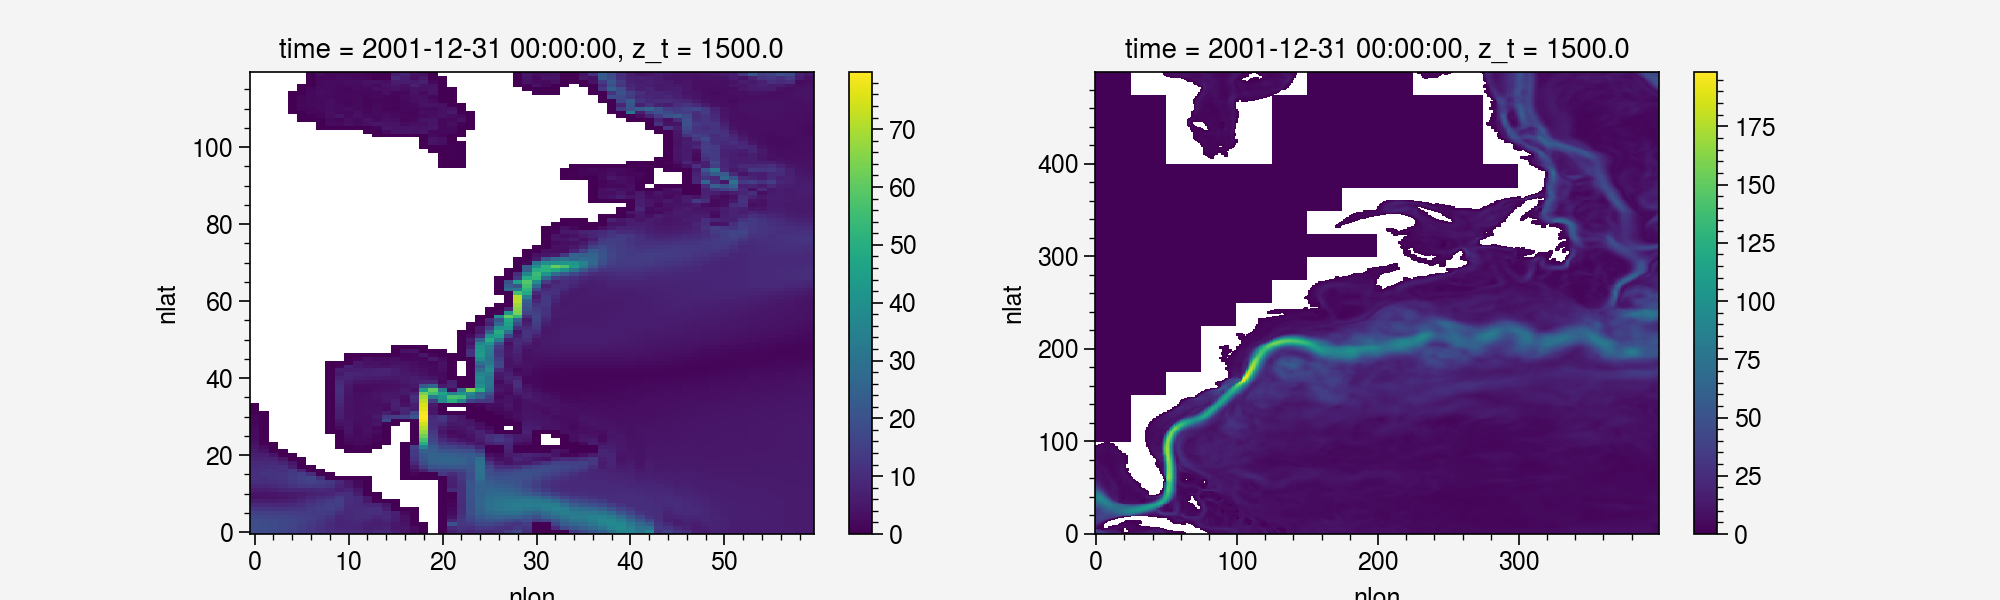

In [15]:
%%time
v_r_z1_TH = ds_vvel_TH.VVEL.isel(nlat=slice(nlat1_r_t12, nlat2_r_t12), nlon=slice(nlon1_r_t12, nlon2_r_t12)).sel(z_t=15*100, method='nearest')
u_r_z1_TH = ds_uvel_TH.UVEL.isel(nlat=slice(nlat1_r_t12, nlat2_r_t12), nlon=slice(nlon1_r_t12, nlon2_r_t12)).sel(z_t=15*100, method='nearest')
spd_r_z1_TH = xr.ufuncs.sqrt(u_r_z1_TH**2 + v_r_z1_TH**2)
print(ds_vvel_TH.time)
time_s_TH = ds_vvel_TH.time.to_pandas().index.shift(-1,'D') 
spd_r_z1_TH = spd_r_z1_TH.assign_coords(time=time_s_TH)
spd_r_z1_tre_TH = spd_r_z1_TH.resample(time='A').mean('time').compute()

v_r_z1_CH = ds_vvel_CH.VVEL.isel(nlat=slice(nlat1_r_t12, nlat2_r_t12), nlon=slice(nlon1_r_t12, nlon2_r_t12)).sel(z_t=15*100, method='nearest')
u_r_z1_CH = ds_uvel_CH.UVEL.isel(nlat=slice(nlat1_r_t12, nlat2_r_t12), nlon=slice(nlon1_r_t12, nlon2_r_t12)).sel(z_t=15*100, method='nearest')
spd_r_z1_CH = xr.ufuncs.sqrt(u_r_z1_CH**2 + v_r_z1_CH**2)
print(ds_vvel_CH.time)
time_s_CH = ds_vvel_CH.time.to_pandas().index.shift(-1,'D') 
spd_r_z1_CH = spd_r_z1_CH.assign_coords(time=time_s_CH)
spd_r_z1_tre_CH = spd_r_z1_CH.resample(time='A').mean('time').compute()

spd_r_z1_tre_THmCH = spd_r_z1_tre_TH-spd_r_z1_tre_CH.values

v_r_z1_TL = ds_vvel_TL.VVEL.isel(nlat=slice(nlat1_r_g16, nlat2_r_g16), nlon=slice(nlon1_r_g16, nlon2_r_g16)).sel(z_t=15*100, method='nearest')
u_r_z1_TL = ds_uvel_TL.UVEL.isel(nlat=slice(nlat1_r_g16, nlat2_r_g16), nlon=slice(nlon1_r_g16, nlon2_r_g16)).sel(z_t=15*100, method='nearest')
spd_r_z1_TL = xr.ufuncs.sqrt(u_r_z1_TL**2 + v_r_z1_TL**2)
print(ds_vvel_TL.time)
time_s_TL = ds_vvel_TL.time.to_pandas().index.shift(-1,'D') 
spd_r_z1_TL = spd_r_z1_TL.assign_coords(time=time_s_TL)
spd_r_z1_tre_TL = spd_r_z1_TL.resample(time='A').mean('time').compute()

v_r_z1_CL = ds_vvel_CL.VVEL.isel(nlat=slice(nlat1_r_g16, nlat2_r_g16), nlon=slice(nlon1_r_g16, nlon2_r_g16)).sel(z_t=15*100, method='nearest')
u_r_z1_CL = ds_uvel_CL.UVEL.isel(nlat=slice(nlat1_r_g16, nlat2_r_g16), nlon=slice(nlon1_r_g16, nlon2_r_g16)).sel(z_t=15*100, method='nearest')
spd_r_z1_CL = xr.ufuncs.sqrt(u_r_z1_CL**2 + v_r_z1_CL**2)
print(ds_vvel_CL.time)
time_s_CL = ds_vvel_CL.time.to_pandas().index.shift(-1,'D') 
spd_r_z1_CL = spd_r_z1_CL.assign_coords(time=time_s_CL)
spd_r_z1_tre_CL = spd_r_z1_CL.resample(time='A').mean('time').compute()

spd_r_z1_tre_TLmCL = spd_r_z1_tre_TL-spd_r_z1_tre_CL.values

fig, axs = plt.subplots(1,2,figsize=(10,3))
spd_r_z1_tre_TL.isel(time=0).plot(ax=axs[0])
spd_r_z1_tre_TH.isel(time=0).plot(ax=axs[1])

In [16]:
%%time 
print('spd_r_z1_tre_THmCH.dims', spd_r_z1_tre_THmCH.dims)
_, nlat_r_t12, nlon_r_t12 = spd_r_z1_tre_THmCH.shape

spd2amoc_r_THmCH = np.empty((nlat_r_t12, nlon_r_t12))
spd2amoc_r_THmCH[:] = np.nan
pspd2_r_THmCH = np.empty((nlat_r_t12, nlon_r_t12))
pspd2_r_THmCH[:] = np.nan


for ilon in np.arange(0,nlon_r_t12):
    for ilat in np.arange(0,nlat_r_t12):
#         slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        spd2amoc_r_THmCH[ilat,ilon], _, _, pspd2_r_THmCH[ilat,ilon], _ = stats.linregress(
            amoc_lat1z1_tre_THmCH, spd_r_z1_tre_THmCH[:,ilat,ilon])

lat_r_t12 = ds_r_t12.TLAT
latmspd2_r_t12 = np.where(pspd2_r_THmCH>0.1,lat_r_t12, np.nan) # m: mask

lon_r_t12 = ds_r_t12.TLONG
lonmspd2_r_t12 = np.where(pspd2_r_THmCH>0.1,lon_r_t12, np.nan) # m: mask

spd_r_z1_tre_THmCH.dims ('time', 'nlat', 'nlon')
CPU times: user 2min 54s, sys: 766 ms, total: 2min 55s
Wall time: 2min 55s


In [17]:
%%time 
print('spd_r_z1_tre_TLmCL.dim', spd_r_z1_tre_TLmCL.dims)
_, nlat_r_g16, nlon_r_g16 = spd_r_z1_tre_TLmCL.shape

spd2amoc_r_TLmCL = np.empty((nlat_r_g16, nlon_r_g16))
spd2amoc_r_TLmCL[:] = np.nan
pspd2_r_TLmCL = np.empty((nlat_r_g16, nlon_r_g16))
pspd2_r_TLmCL[:] = np.nan


for ilon in np.arange(0,nlon_r_g16):
    for ilat in np.arange(0,nlat_r_g16):
#         slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        spd2amoc_r_TLmCL[ilat,ilon], _, _, pspd2_r_TLmCL[ilat,ilon], _ = stats.linregress(
            amoc_lat1z1_tre_TLmCL, spd_r_z1_tre_TLmCL[:,ilat,ilon])

lat_r_g16 = ds_r_g16.TLAT#.where(px_NA_TLmCL>0.05)
latmspd2_r_g16 = np.where(pspd2_r_TLmCL>0.1,lat_r_g16, np.nan) # m: mask

lon_r_g16 = ds_r_g16.TLONG#.where(px_NA_TLmCL>0.05)
lonmspd2_r_g16 = np.where(pspd2_r_TLmCL>0.1,lon_r_g16, np.nan) # m: mask

spd_r_z1_tre_TLmCL.dim ('time', 'nlat', 'nlon')
CPU times: user 6.28 s, sys: 25.9 ms, total: 6.31 s
Wall time: 6.32 s


Text(0.5, 1.0, 'LON LR')

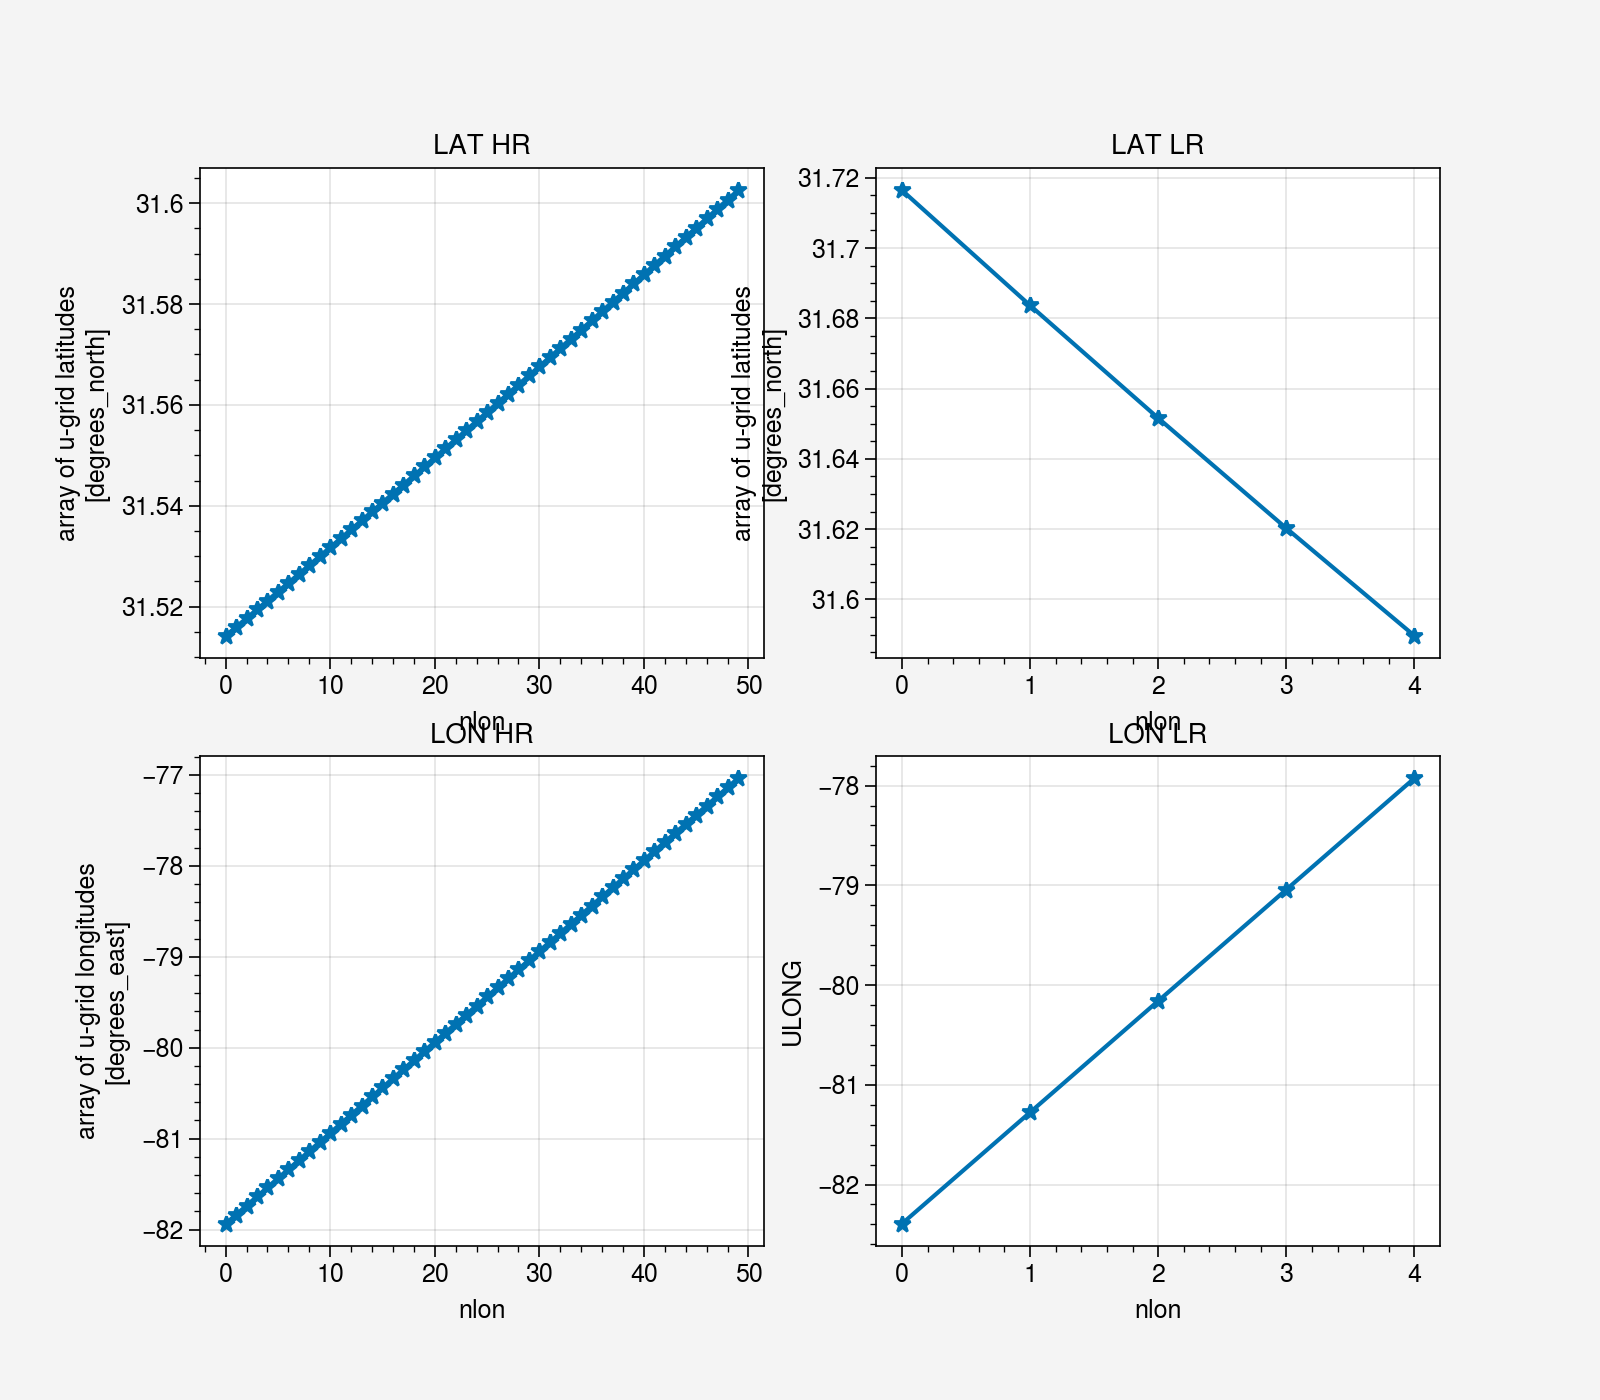

In [18]:
ilat1_t12 = 1517
ilon1_t12, ilon2_t12 = 280, 320+10

ilat1_g16 = 281
ilon1_g16, ilon2_g16 = 281, 286

fig, axs = plt.subplots(2,2,figsize=(8,7))
ds_vvel_TH.ULAT.isel(nlat=ilat1_t12,nlon=slice(ilon1_t12,ilon2_t12)).plot(ax=axs[0,0], marker='*')
axs[0,0].set_title('LAT HR')
# print('mean lat (t12):',ds_vvel_TH.ULAT.isel(nlat=ilat1_t12,nlon=slice(ilon1_t12,ilon2_t12)).mean().values)

ds_vvel_TL.ULAT.isel(nlat=ilat1_g16,nlon=slice(ilon1_g16,ilon2_g16)).plot(ax=axs[0,1], marker='*')
axs[0,1].set_title('LAT LR')
# print('mean lat (g16):',ds0_TL.ULAT.isel(nlat=ilat1_g16,nlon=slice(ilon1_g16,ilon2_g16)).mean().values)

ds_vvel_TH.ULONG.isel(nlat=ilat1_t12,nlon=slice(ilon1_t12,ilon2_t12)).plot(ax=axs[1,0], marker='*')
axs[1,0].set_title('LON HR')
# print('mean lon (t12):',ds_vvel_TH.ULONG.isel(nlat=ilat1_t12,nlon=slice(ilon1_t12,ilon2_t12)).mean().values)

(ds_vvel_TL.ULONG.isel(nlat=ilat1_g16,nlon=slice(ilon1_g16,ilon2_g16))-360).plot(ax=axs[1,1], marker='*')
axs[1,1].set_title('LON LR')
# print('mean lon (g16):', ds0_TL.ULONG.isel(nlat=ilat1_g16,nlon=slice(ilon1_g16,ilon2_g16)).mean().values-360)

/ihesp/software/conda/envs/xroms_unstable_daskpr/lib/python3.7/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/ihesp/software/conda/envs/xroms_unstable_daskpr/lib/python3.7/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/ihesp/software/conda/envs/xroms_unstable_daskpr/lib/python3.7/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/ihesp/software/conda/envs/xroms_unstable_daskpr/lib/python3.7/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/ihesp/software/conda/envs/xroms_unstable_daskpr/lib/python3.7/site-packages/numpy/core/_methods.py:179: RuntimeWarning: inv

CPU times: user 2.61 s, sys: 94.6 ms, total: 2.71 s
Wall time: 6min 9s


<xarray.DataArray (time: 100, z_t: 62, nlon: 50)>
array([[[        nan,         nan,         nan, ...,  3.6013546 ,
          3.5308123 , -0.2725048 ],
        [        nan,         nan,         nan, ...,  4.2655716 ,
          4.1920967 ,  0.50351524],
        [        nan,         nan,         nan, ...,  4.537861  ,
          3.7859545 , -0.02769089],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ..., -6.114583  ,
         -4.57423   , -4.403652  ],
        [        nan,         nan,         nan, ..., -6.2305193 ,
         -5.104887  , -4.8975115 ],
        [        nan,         nan,         nan, ..., -5.6470404 ,
         -4.952322  , -4.852907  ],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ..., -1.4440327 ,
          0.63705826,  1.4965744 ],
        [        nan,         nan,         nan, ..., -2.3087997 ,
         -0.1792202 ,  0.60816765],
        [        nan,         nan,         nan, ..., -2.4350967 ,
         -0.5032654 ,  0.05800438],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]], dtype=float32)
Coordinates:
  * time     (time) object 2001-12-31 00:00:00 ... 2100-12-31 00:00:00
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
    ULONG    (nlon) float64 -81.93 -81.84 -81.74 -81.64 ... -77.24 -77.14 -77.04
    ULAT     (nlon) float64 31.51 31.52 31.52 31.52 ... 31.6 31.6 31.6 31.6
    TLONG    (nlon) float64 278.0 278.1 278.2 278.3 ... 282.6 282.7 282.8 282.9
    TLAT     (nlon) float64 31.47 31.48 31.48 31.48 ... 31.56 31.56 31.56 31.56
Dimensions without coordinates: nlon

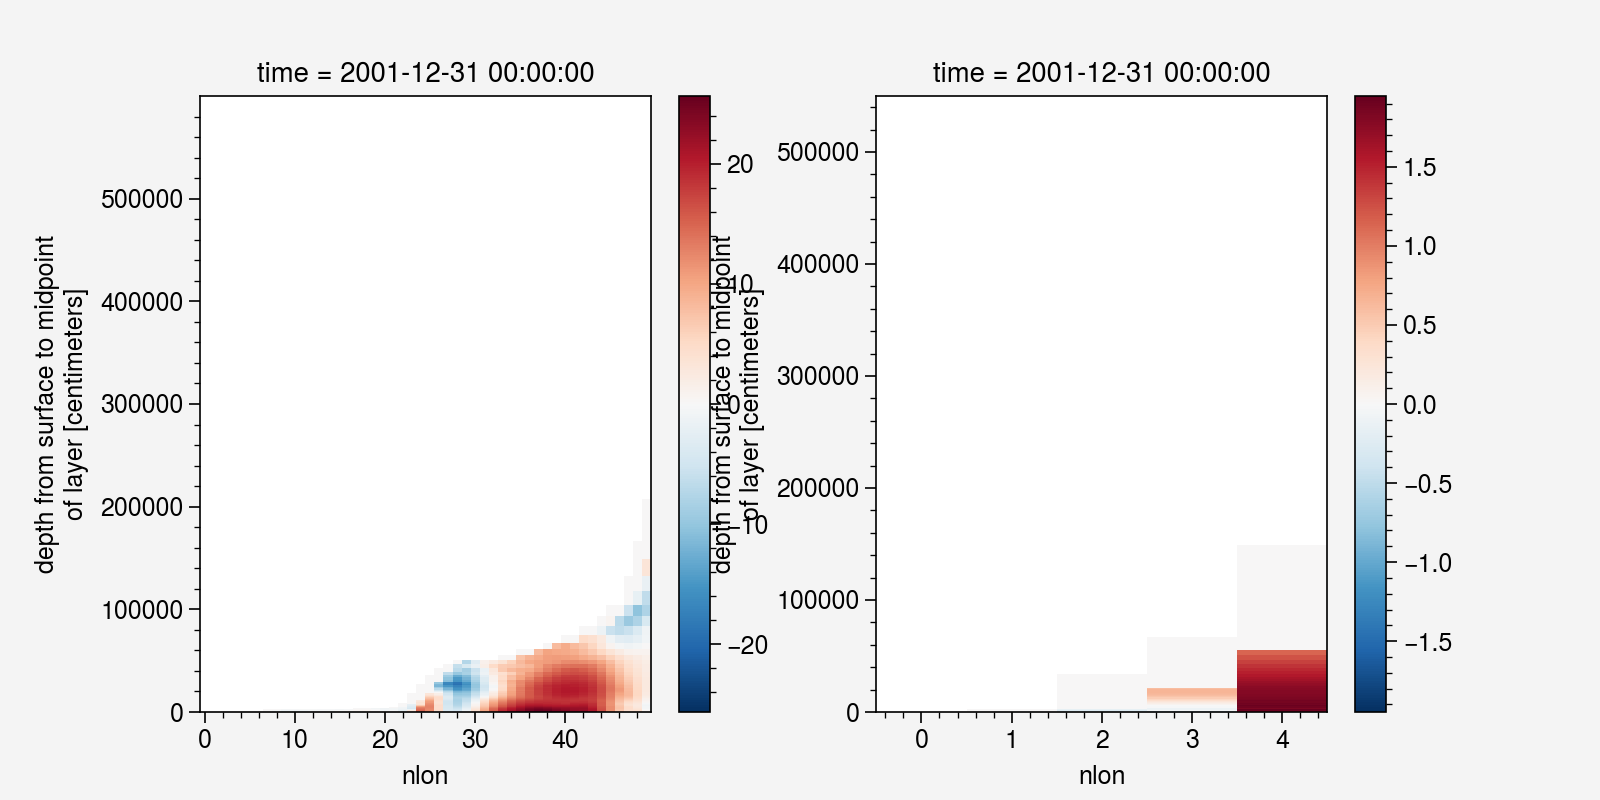

In [19]:
%%time
v_sec1_TH = ds_vvel_TH.VVEL.isel(nlat=ilat1_t12,nlon=slice(ilon1_t12,ilon2_t12))
u_sec1_TH = ds_uvel_TH.UVEL.isel(nlat=ilat1_t12,nlon=slice(ilon1_t12,ilon2_t12))
spd_sec1_TH = xr.ufuncs.sqrt(u_sec1_TH**2 + v_sec1_TH**2)
spd_sec1_TH = spd_sec1_TH.assign_coords(time=time_s_TH)
spd_sec1_tre_TH = spd_sec1_TH.resample(time='A').mean('time').compute()

v_sec1_CH = ds_vvel_CH.VVEL.isel(nlat=ilat1_t12,nlon=slice(ilon1_t12,ilon2_t12))
u_sec1_CH = ds_uvel_CH.UVEL.isel(nlat=ilat1_t12,nlon=slice(ilon1_t12,ilon2_t12))
spd_sec1_CH = xr.ufuncs.sqrt(u_sec1_CH**2 + v_sec1_CH**2)
spd_sec1_CH = spd_sec1_CH.assign_coords(time=time_s_CH)
spd_sec1_tre_CH = spd_sec1_CH.resample(time='A').mean('time').compute()

spd_sec1_tre_THmCH = spd_sec1_tre_TH - spd_sec1_tre_CH.values


v_sec1_TL = ds_vvel_TL.VVEL.isel(nlat=ilat1_g16,nlon=slice(ilon1_g16,ilon2_g16))
u_sec1_TL = ds_uvel_TL.UVEL.isel(nlat=ilat1_g16,nlon=slice(ilon1_g16,ilon2_g16))
spd_sec1_TL = xr.ufuncs.sqrt(u_sec1_TL**2 + v_sec1_TL**2)
spd_sec1_TL = spd_sec1_TL.assign_coords(time=time_s_TL)
spd_sec1_tre_TL = spd_sec1_TL.resample(time='A').mean('time').compute()

v_sec1_CL = ds_vvel_CL.VVEL.isel(nlat=ilat1_g16,nlon=slice(ilon1_g16,ilon2_g16))
u_sec1_CL = ds_uvel_CL.UVEL.isel(nlat=ilat1_g16,nlon=slice(ilon1_g16,ilon2_g16))
spd_sec1_CL = xr.ufuncs.sqrt(u_sec1_CL**2 + v_sec1_CL**2)
spd_sec1_CL = spd_sec1_CL.assign_coords(time=time_s_CL)
spd_sec1_tre_CL = spd_sec1_CL.resample(time='A').mean('time').compute()


spd_sec1_tre_TLmCL = spd_sec1_tre_TL - spd_sec1_tre_CL.values

fig, axs = plt.subplots(1,2,figsize=(8,4))
spd_sec1_tre_THmCH.isel(time=0).plot(ax=axs[0])
spd_sec1_tre_TLmCL.isel(time=0).plot(ax=axs[1])
spd_sec1_tre_THmCH

In [20]:
%%time 
print('spd_sec1_z1_tre_THmCH.dims', spd_sec1_tre_THmCH.dims)
_, nz_sec1_t12, nlon_sec1_t12 = spd_sec1_tre_THmCH.shape

spd2amoc_sec1_THmCH = np.empty((nz_sec1_t12, nlon_sec1_t12))
spd2amoc_sec1_THmCH[:] = np.nan
pspd2_sec1_THmCH = np.empty((nz_sec1_t12, nlon_sec1_t12))
pspd2_sec1_THmCH[:] = np.nan


for ilon in np.arange(0,nlon_sec1_t12):
    for iz in np.arange(0,nz_sec1_t12):
#         slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        spd2amoc_sec1_THmCH[iz,ilon], _, _, pspd2_sec1_THmCH[iz,ilon], _ = stats.linregress(
            amoc_lat1z1_tre_THmCH, spd_sec1_tre_THmCH[:,iz,ilon])

print(spd2amoc_sec1_THmCH.shape)
print(spd_sec1_tre_THmCH.z_t.shape)
print(spd_sec1_tre_THmCH.z_t.values[:,np.newaxis].shape)
z_sec1_THmCH = np.tile(spd_sec1_tre_THmCH.z_t.values[:,np.newaxis],(1,len(spd_sec1_tre_THmCH.ULONG)))
print(z_sec1_THmCH.shape)

print(spd_sec1_tre_THmCH.ULONG.shape)
print(spd_sec1_tre_THmCH.ULONG.values[np.newaxis,:].shape)
lon_sec1_THmCH = np.tile(spd_sec1_tre_THmCH.ULONG.values[np.newaxis,:],(len(spd_sec1_tre_THmCH.z_t),1))
print(lon_sec1_THmCH.shape)

zm_sec1_THmCH = np.where(pspd2_sec1_THmCH>0.1, z_sec1_THmCH, np.nan) # m: mask
lonm_sec1_THmCH = np.where(pspd2_sec1_THmCH>0.1,lon_sec1_THmCH, np.nan) # m: mask

spd_sec1_z1_tre_THmCH.dims ('time', 'z_t', 'nlon')
(62, 50)
(62,)
(62, 1)
(62, 50)
(50,)
(1, 50)
(62, 50)
CPU times: user 2.69 s, sys: 18 ms, total: 2.71 s
Wall time: 2.7 s


In [21]:
%%time 
print('spd_sec1_z1_tre_TLmCL.dims', spd_sec1_tre_TLmCL.dims)
_, nz_sec1_g16, nlon_sec1_g16 = spd_sec1_tre_TLmCL.shape

spd2amoc_sec1_TLmCL = np.empty((nz_sec1_g16, nlon_sec1_g16))
spd2amoc_sec1_TLmCL[:] = np.nan
pspd2_sec1_TLmCL = np.empty((nz_sec1_g16, nlon_sec1_g16))
pspd2_sec1_TLmCL[:] = np.nan


for ilon in np.arange(0,nlon_sec1_g16):
    for iz in np.arange(0,nz_sec1_g16):
#         slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        spd2amoc_sec1_TLmCL[iz,ilon], _, _, pspd2_sec1_TLmCL[iz,ilon], _ = stats.linregress(
            amoc_lat1z1_tre_TLmCL, spd_sec1_tre_TLmCL[:,iz,ilon])

print(spd2amoc_sec1_TLmCL.shape)
print(spd_sec1_tre_TLmCL.z_t.shape)
print(spd_sec1_tre_TLmCL.z_t.values[:,np.newaxis].shape)
z_sec1_TLmCL = np.tile(spd_sec1_tre_TLmCL.z_t.values[:,np.newaxis],(1,len(spd_sec1_tre_TLmCL.ULONG)))
print(z_sec1_TLmCL.shape)

print(spd_sec1_tre_TLmCL.ULONG.shape)
print(spd_sec1_tre_TLmCL.ULONG.values[np.newaxis,:].shape)
lon_sec1_TLmCL = np.tile(spd_sec1_tre_TLmCL.ULONG.values[np.newaxis,:],(len(spd_sec1_tre_TLmCL.z_t),1))
print(lon_sec1_TLmCL.shape)

zm_sec1_TLmCL = np.where(pspd2_sec1_TLmCL>0.1, z_sec1_TLmCL, np.nan) # m: mask
lonm_sec1_TLmCL = np.where(pspd2_sec1_TLmCL>0.1,lon_sec1_TLmCL, np.nan) # m: mask

spd_sec1_z1_tre_TLmCL.dims ('time', 'z_t', 'nlon')
(60, 5)
(60,)
(60, 1)
(60, 5)
(5,)
(1, 5)
(60, 5)
CPU times: user 270 ms, sys: 2.06 ms, total: 272 ms
Wall time: 265 ms


In [22]:
# %%time 
# print('spd_sec1_z1_tre_THmCH.dims', spd_sec1_tre_THmCH.dims)
# _, nlat_sec1_t12, nlon_sec1_t12 = spd_sec1_tre_THmCH.shape

# spd2amoc_sec1_THmCH = np.empty((nlat_sec1_t12, nlon_sec1_t12))
# spd2amoc_sec1_THmCH[:] = np.nan
# pspd2_sec1_THmCH = np.empty((nlat_sec1_t12, nlon_sec1_t12))
# pspd2_sec1_THmCH[:] = np.nan


# for ilon in np.arange(0,nlon_sec1_t12):
#     for ilat in np.arange(0,nlat_sec1_t12):
# #         slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
#         spd2amoc_sec1_THmCH[ilat,ilon], _, _, pspd2_sec1_THmCH[ilat,ilon], _ = stats.linregress(
#             amoc_lat1z1_tre_THmCH, spd_sec1_tre_THmCH[:,ilat,ilon])

# lat_sec1_t12 = ds_t12.TLAT.isel(nlat=ilat1_t12,nlon=slice(ilon1_t12,ilon2_t12))
# latmspd2_sec1_t12 = np.where(pspd2_sec1_THmCH>0.1,lat_sec1_t12, np.nan) # m: mask

# lon_sec1_t12 = ds_t12.TLONG.isel(nlat=ilat1_t12,nlon=slice(ilon1_t12,ilon2_t12))
# lonmspd2_sec1_t12 = np.where(pspd2_sec1_THmCH>0.1,lon_sec1_t12, np.nan) # m: mask

In [23]:
# %%time 
# print('spd_sec1_z1_tre_TLmCL.dims', spd_sec1_tre_TLmCL.dims)
# _, nlat_sec1_g16, nlon_sec1_g16 = spd_sec1_tre_TLmCL.shape

# spd2amoc_sec1_TLmCL = np.empty((nlat_sec1_g16, nlon_sec1_g16))
# spd2amoc_sec1_TLmCL[:] = np.nan
# pspd2_sec1_TLmCL = np.empty((nlat_sec1_g16, nlon_sec1_g16))
# pspd2_sec1_TLmCL[:] = np.nan


# for ilon in np.arange(0,nlon_sec1_g16):
#     for ilat in np.arange(0,nlat_sec1_g16):
# #         slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
#         spd2amoc_sec1_TLmCL[ilat,ilon], _, _, pspd2_sec1_TLmCL[ilat,ilon], _ = stats.linregress(
#             amoc_lat1z1_tre_TLmCL, spd_sec1_tre_TLmCL[:,ilat,ilon])

# lat_sec1_g16 = ds_g16.TLAT.isel(nlat=ilat1_g16,nlon=slice(ilon1_g16,ilon2_g16))
# latmspd2_sec1_g16 = np.where(pspd2_sec1_TLmCL>0.1,lat_sec1_g16, np.nan) # m: mask

# lon_sec1_g16 = ds_g16.TLONG.isel(nlat=ilat1_g16,nlon=slice(ilon1_g16,ilon2_g16))
# lonmspd2_sec1_g16 = np.where(pspd2_sec1_TLmCL>0.1,lon_sec1_g16, np.nan) # m: mask

# make pics

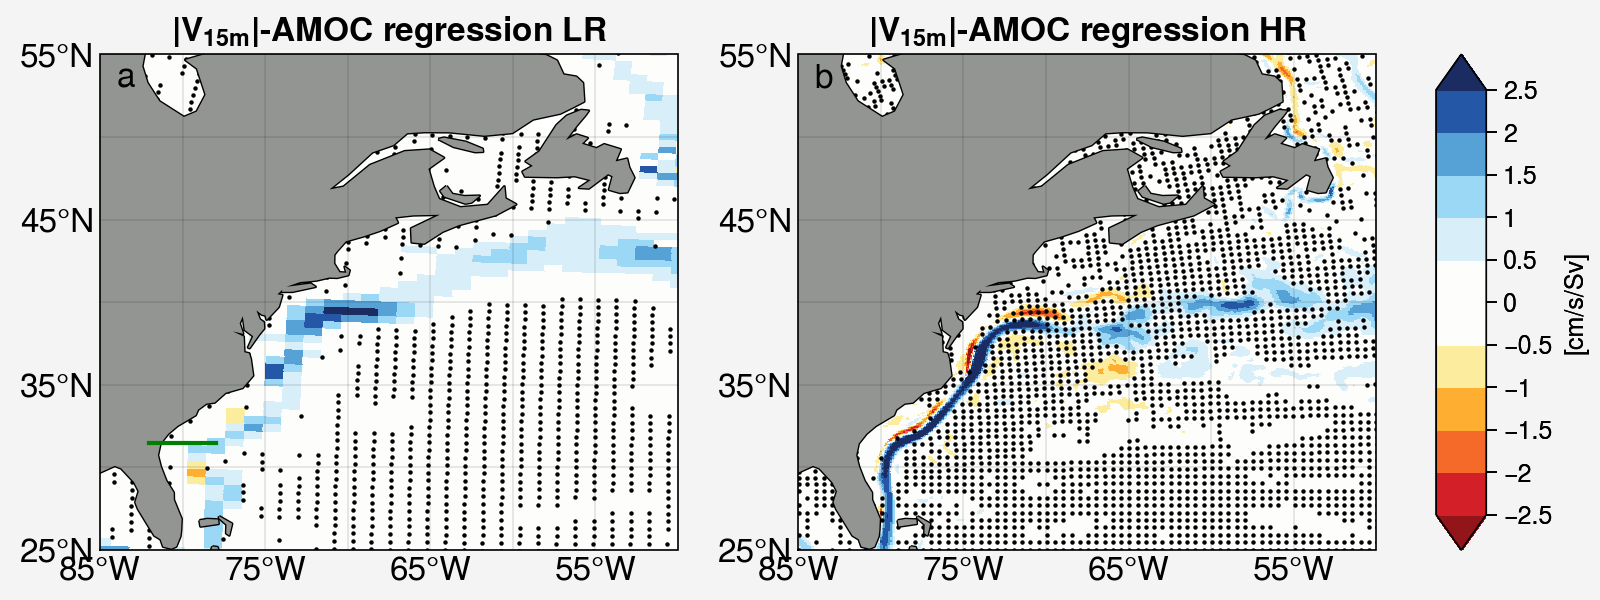

In [45]:
pc = cartopy.crs.PlateCarree()
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()



fig1, axs = plot.subplots(nrows=1,ncols=2,proj='cyl',width='8in',height='3in',share=False)
cut=-0.1
m00=axs[0,0].pcolormesh(ds_r_g16.ULONG, ds_r_g16.ULAT, 
        spd2amoc_r_TLmCL,levels=np.arange(-2.5, 2.5+0.1, 0.5), 
        transform=pc, cmap="ColdHot_r", cmap_kw={'cut': cut}, extend='both')
axs[0,0].scatter(lonmspd2_r_g16,latmspd2_r_g16,transform=pc, marker='o',s=1,c='k')
axs[0,0].plot([-82,-78],[31.5,31.5],transform=pc,c='g')
axs[0,0].coastlines(resolution='110m', color='black', linewidth=1)
axs[0,0].format(land=True, landcolor='grey')
axs[0,0].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[0,0].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[0,0].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[0,0].xaxis.set_major_formatter(lon_formatter)
axs[0,0].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[0,0].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[0,0].yaxis.set_major_formatter(lat_formatter)
axs[0,0].set_title(r'$|V_{15m}|$-AMOC regression LR', fontsize=12, fontweight='bold')
axs[0,0].text(-84, 53, 'a', transform=pc, fontsize=12)


m01=axs[0,1].pcolormesh(ds_r_t12.ULONG, ds_r_t12.ULAT, 
        spd2amoc_r_THmCH,levels=np.arange(-2.5, 2.5+0.1, 0.5), 
        transform=pc, cmap="ColdHot_r", cmap_kw={'cut': cut}, extend='both')
axs[0,1].scatter(lonmspd2_r_t12[::5,::5],latmspd2_r_t12[::5,::5],transform=pc, marker='o',s=1,c='k')
axs[0,1].coastlines(resolution='110m', color='black', linewidth=1)
axs[0,1].format(land=True, landcolor='grey')
axs[0,1].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[0,1].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[0,1].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[0,1].xaxis.set_major_formatter(lon_formatter)
axs[0,1].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[0,1].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[0,1].yaxis.set_major_formatter(lat_formatter)
axs[0,1].set_title(r'$|V_{15m}|$-AMOC regression HR', fontsize=12, fontweight='bold')
axs[0,1].text(-84, 53, 'b', transform=pc, fontsize=12)
# add colorbar
cb = axs[0,1].colorbar(m01,loc='r', label='[cm/s/Sv]',width='2em')

outdir = '/scratch/user/dapengli/Projects4iHESP/Project_SeaLevelUSEastCoast_2021Mar30/pics/'
pic1 = outdir + 'VEL_AMOCregressionUSeastCost4reviewer2_2022Feb07.png'

fig1.savefig(pic1,bbox_inches='tight')

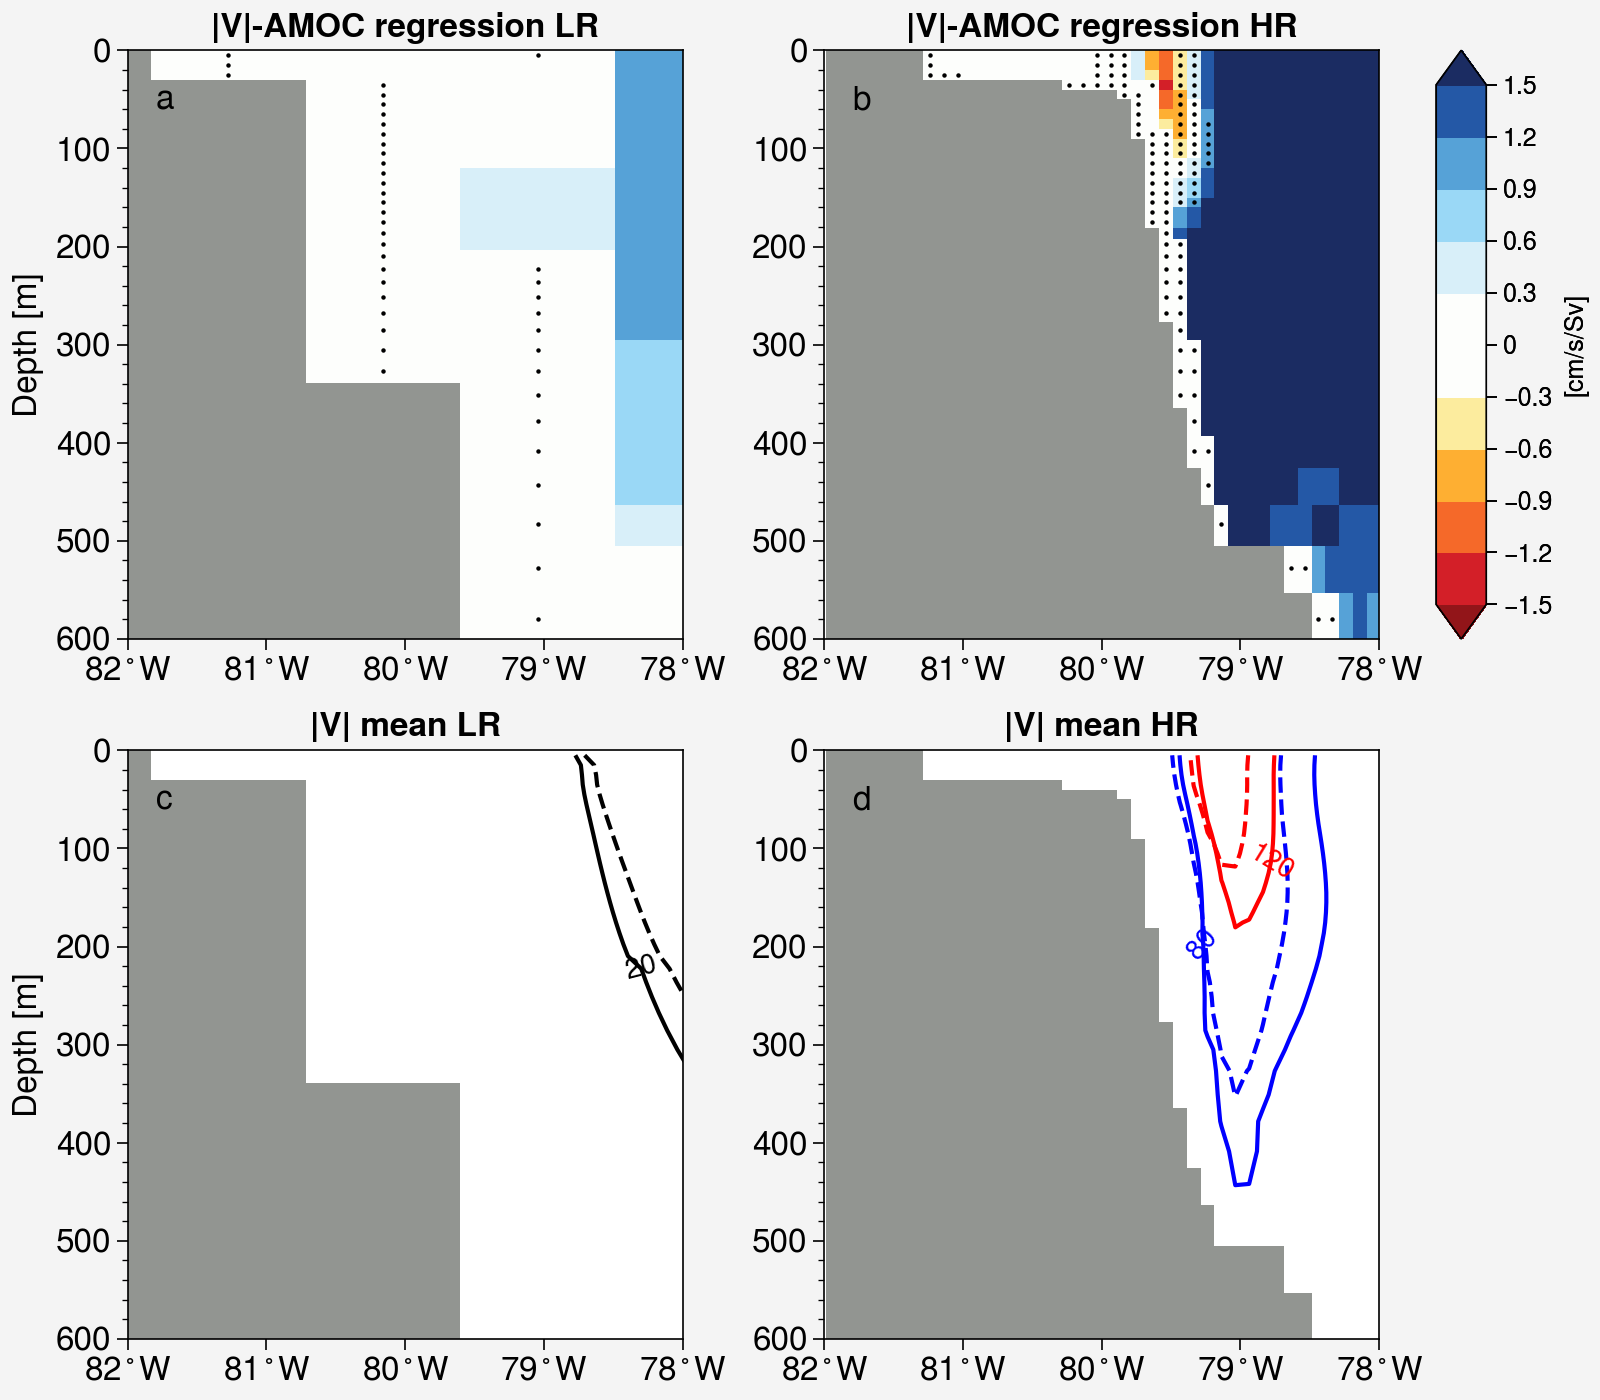

In [46]:
cmap2 = plot.Colormap('ColdHot_r') # create a colopmap with white in central(cut=-0.1) and grey for nan (lands)
cmap2.set_bad(color='grey')

from matplotlib import colors
cmap3 = colors.ListedColormap(['white', 'grey'])

cut=-0.1

xlim1_plt, xlim2_plt = -82,-78
xticks_plt = np.arange(-82,-78+0.1,1)
xtickslabel_plt = ['82$^\circ$W','81$^\circ$W','80$^\circ$W','79$^\circ$W','78$^\circ$W']
ylim1_plt, ylim2_plt = 0, 600

x4text, y4text = -81.8, 60

fig2, axs = plot.subplots(nrows=2,ncols=2, width='8in',height='7in',share=False)

m00 = axs[0,0].pcolormesh(spd_sec1_tre_TLmCL.ULONG-360, spd_sec1_tre_TLmCL.z_t/100, spd2amoc_sec1_TLmCL, 
                          cmap=cmap2, levels=np.arange(-1.5, 1.5+0.1, 0.3),cmap_kw={'cut': cut}, extend='both')
axs[0,0].scatter(lonm_sec1_TLmCL-360,zm_sec1_TLmCL/100, marker='o',s=1,c='k')
axs[0,0].set_xticks(xticks_plt)
axs[0,0].set_xticklabels(xtickslabel_plt, fontsize=12)
axs[0,0].set_xlim([xlim1_plt, xlim2_plt])
axs[0,0].tick_params(axis='x', which='minor', bottom=False)
axs[0,0].set_ylim([ylim1_plt, ylim2_plt])
axs[0,0].invert_yaxis()
axs[0,0].set_xlabel('')
axs[0,0].tick_params(axis='both', which='major', labelsize=12)
axs[0,0].set_ylabel('Depth [m]', fontsize=12)
axs[0,0].set_title('|V|-AMOC regression LR', fontsize=12, fontweight='bold')
axs[0,0].text(x4text, y4text, 'a', fontsize=12)

m01 = axs[0,1].pcolormesh(spd_sec1_tre_THmCH.ULONG, spd_sec1_tre_THmCH.z_t/100, spd2amoc_sec1_THmCH, 
                          cmap=cmap2, levels=np.arange(-1.5, 1.5+0.1, 0.3),cmap_kw={'cut': cut}, extend='both')
axs[0,1].scatter(lonm_sec1_THmCH,zm_sec1_THmCH/100, marker='o',s=1,c='k')
axs[0,1].set_xticks(xticks_plt)
axs[0,1].set_xticklabels(xtickslabel_plt, fontsize=12)
axs[0,1].set_xlim([xlim1_plt, xlim2_plt])
axs[0,1].tick_params(axis='x', which='minor', bottom=False)
axs[0,1].set_ylim([ylim1_plt, ylim2_plt])
axs[0,1].set_ylabel('')
axs[0,1].invert_yaxis()
axs[0,1].set_xlabel('')
axs[0,1].tick_params(axis='both', which='major', labelsize=12)
axs[0,1].set_title('|V|-AMOC regression HR', fontsize=12, fontweight='bold')
axs[0,1].text(x4text, y4text, 'b', fontsize=12)
cb = axs[0,1].colorbar(m01,loc='r',label='[cm/s/Sv]',width='2em',shrink=1)



spd_sec1_t1av_TL = spd_sec1_tre_TL.sel(time=slice('2001','2020')).mean('time').compute()
spd_sec1_t2av_TL = spd_sec1_tre_TL.sel(time=slice('2081','2100')).mean('time').compute()

spd_sec1_t1av_TH = spd_sec1_tre_TH.sel(time=slice('2001','2020')).mean('time').compute()
spd_sec1_t2av_TH = spd_sec1_tre_TH.sel(time=slice('2081','2100')).mean('time').compute()



axs[1,0].pcolormesh(spd_sec1_tre_TLmCL.ULONG-360, spd_sec1_tre_TLmCL.z_t/100, xr.ufuncs.isnan(spd_sec1_t2av_TL), 
                         cmap=cmap3)
cs10 = axs[1,0].contour(spd_sec1_tre_TLmCL.ULONG-360, spd_sec1_tre_TLmCL.z_t/100, spd_sec1_t1av_TL, 
                        levels=[20], color='k')
axs[1,0].clabel(cs10, inline=False, fmt='%d', fontsize=10,)
m10 = axs[1,0].contour(spd_sec1_tre_TLmCL.ULONG-360, spd_sec1_tre_TLmCL.z_t/100, spd_sec1_t2av_TL, 
                       levels=[20], linestyle='--', color='k')
axs[1,0].set_xticks(xticks_plt)
axs[1,0].set_xticklabels(xtickslabel_plt, fontsize=12)
axs[1,0].set_xlim([xlim1_plt, xlim2_plt])
axs[1,0].tick_params(axis='x', which='minor', bottom=False)
axs[1,0].set_ylim([ylim1_plt, ylim2_plt])
axs[1,0].set_ylabel('Depth [m]', fontsize=12)
axs[1,0].set_xlabel('')
axs[1,0].invert_yaxis()
axs[1,0].tick_params(axis='both', which='major', labelsize=12)
axs[1,0].set_title('|V| mean LR', fontsize=12, fontweight='bold')
axs[1,0].text(x4text, y4text, 'c', fontsize=12)


axs[1,1].pcolormesh(spd_sec1_tre_THmCH.ULONG, spd_sec1_tre_THmCH.z_t/100, xr.ufuncs.isnan(spd_sec1_t2av_TH), 
                       cmap=cmap3)
cs11 = axs[1,1].contour(spd_sec1_tre_THmCH.ULONG, spd_sec1_tre_THmCH.z_t/100, spd_sec1_t1av_TH, 
                        levels=[80],color='b')
axs[1,1].clabel(cs11, inline=False, fmt='%d', fontsize=10,)
axs[1,1].contour(spd_sec1_tre_THmCH.ULONG, spd_sec1_tre_THmCH.z_t/100, spd_sec1_t2av_TH, 
                       levels=[80],linestyle='--',color='b')
cs11 = axs[1,1].contour(spd_sec1_tre_THmCH.ULONG, spd_sec1_tre_THmCH.z_t/100, spd_sec1_t1av_TH, 
                        levels=[120],color='r')
axs[1,1].clabel(cs11, inline=False, fmt='%d', fontsize=10,)
axs[1,1].contour(spd_sec1_tre_THmCH.ULONG, spd_sec1_tre_THmCH.z_t/100, spd_sec1_t2av_TH, 
                       levels=[120],linestyle='--',color='r')
axs[1,1].set_xticks(xticks_plt)
axs[1,1].set_xticklabels(xtickslabel_plt, fontsize=12)
axs[1,1].set_xlim([xlim1_plt, xlim2_plt])
axs[1,1].tick_params(axis='x', which='minor', bottom=False)
axs[1,1].set_ylim([ylim1_plt, ylim2_plt])
axs[1,1].set_ylabel('')
axs[1,1].invert_yaxis()
axs[1,1].set_xlabel('')
axs[1,1].tick_params(axis='both', which='major', labelsize=12)
axs[1,1].set_title('|V| mean HR', fontsize=12, fontweight='bold')
axs[1,1].text(x4text, y4text, 'd', fontsize=12)
# cb = axs[2,0].colorbar(m20,loc='r',label='[cm/s]',width='2em',shrink=1)

outdir = '/scratch/user/dapengli/Projects4iHESP/Project_SeaLevelUSEastCoast_2021Mar30/pics/'
pic2 = outdir + 'VELmeanAMOCregressionUSsoutheastCostCrossSections4reviewer2_2022Feb07.png'

fig2.savefig(pic2,bbox_inches='tight')

# Appendix

In [28]:
from matplotlib import colors
cmap3 = colors.ListedColormap(['white', 'grey'])
# xr.ufuncs.isnan(spd_sec1_t2av_TH).plot(cmap=cmap3)

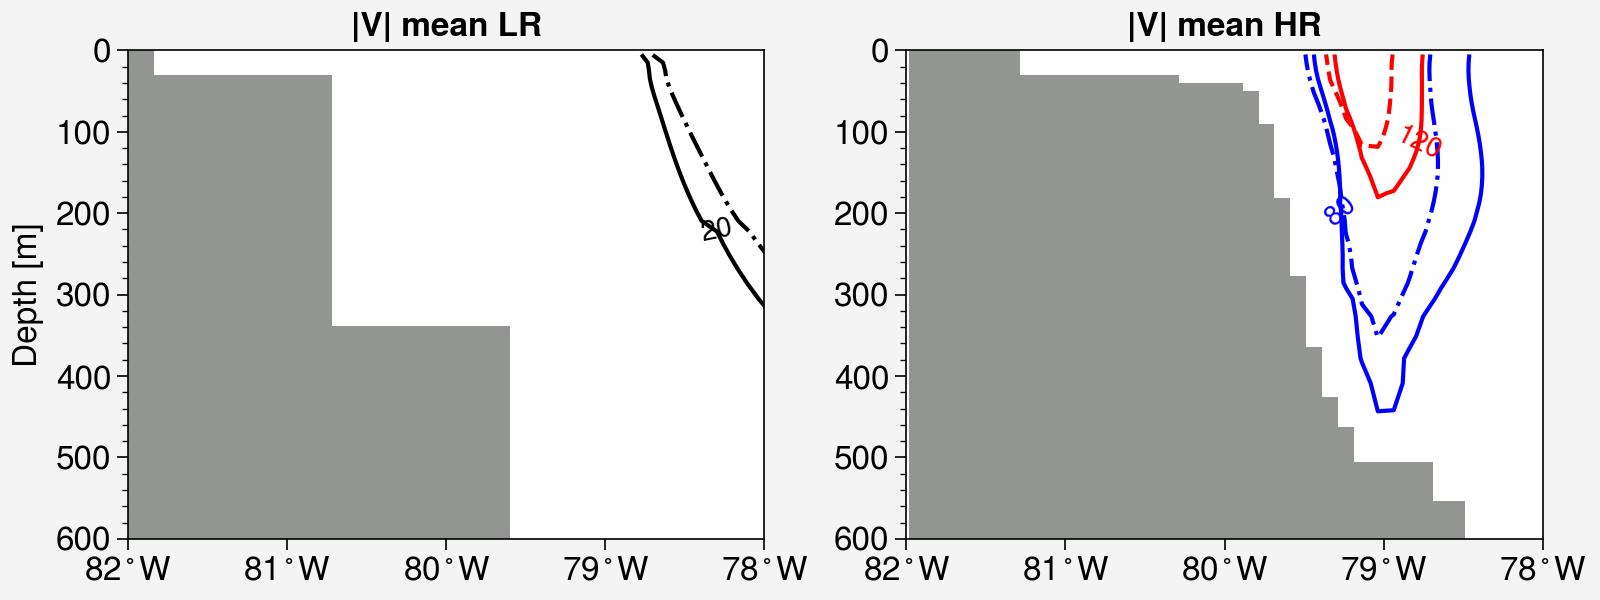

In [29]:
spd_sec1_t1av_TL = spd_sec1_tre_TL.sel(time=slice('2001','2020')).mean('time').compute()
spd_sec1_t2av_TL = spd_sec1_tre_TL.sel(time=slice('2081','2100')).mean('time').compute()

spd_sec1_t1av_TH = spd_sec1_tre_TH.sel(time=slice('2001','2020')).mean('time').compute()
spd_sec1_t2av_TH = spd_sec1_tre_TH.sel(time=slice('2081','2100')).mean('time').compute()

cmap3 = colors.ListedColormap(['white', 'grey'])

xlim1_plt, xlim2_plt = -82,-78
xticks_plt = np.arange(-82,-78+0.1,1)
xtickslabel_plt = ['82$^\circ$W','81$^\circ$W','80$^\circ$W','79$^\circ$W','78$^\circ$W']
ylim1_plt, ylim2_plt = 0, 600

x4text, y4text = -81.8, 60

fig3, axs = plot.subplots(nrows=1,ncols=2, width='8in',height='3in',share=False)

axs[0,0].pcolormesh(spd_sec1_tre_TLmCL.ULONG-360, spd_sec1_tre_TLmCL.z_t/100, xr.ufuncs.isnan(spd_sec1_t2av_TL), 
                         cmap=cmap3)
cs00 = axs[0,0].contour(spd_sec1_tre_TLmCL.ULONG-360, spd_sec1_tre_TLmCL.z_t/100, spd_sec1_t1av_TL, 
                        levels=[20], color='k')
axs[0,0].clabel(cs00, inline=False, fmt='%d', fontsize=10,)
m11 = axs[0,0].contour(spd_sec1_tre_TLmCL.ULONG-360, spd_sec1_tre_TLmCL.z_t/100, spd_sec1_t2av_TL, 
                       levels=[20], linestyle='-.', color='k')
axs[0,0].set_xticks(xticks_plt)
axs[0,0].set_xticklabels(xtickslabel_plt, fontsize=12)
axs[0,0].set_xlim([xlim1_plt, xlim2_plt])
axs[0,0].tick_params(axis='x', which='minor', bottom=False)
axs[0,0].set_ylim([ylim1_plt, ylim2_plt])
axs[0,0].set_ylabel('Depth [m]', fontsize=12)
axs[0,0].set_xlabel('')
axs[0,0].invert_yaxis()
axs[0,0].tick_params(axis='both', which='major', labelsize=12)
axs[0,0].set_title('|V| mean LR', fontsize=12, fontweight='bold')
# axs[0,0].text(x4text, y4text, 'c', fontsize=12)
# cb = axs[2,0].colorbar(m20,loc='r',label='[cm/s]',width='2em',shrink=1)


axs[0,1].pcolormesh(spd_sec1_tre_THmCH.ULONG, spd_sec1_tre_THmCH.z_t/100, xr.ufuncs.isnan(spd_sec1_t2av_TH), 
                       cmap=cmap3)
cs01 = axs[0,1].contour(spd_sec1_tre_THmCH.ULONG, spd_sec1_tre_THmCH.z_t/100, spd_sec1_t1av_TH, 
                        levels=[80],color='b')
axs[0,1].clabel(cs01, inline=False, fmt='%d', fontsize=10,)
axs[0,1].contour(spd_sec1_tre_THmCH.ULONG, spd_sec1_tre_THmCH.z_t/100, spd_sec1_t2av_TH, 
                       levels=[80],linestyle='-.',color='b',label=True,labels_kw={'weight': 'bold'})
cs01 = axs[0,1].contour(spd_sec1_tre_THmCH.ULONG, spd_sec1_tre_THmCH.z_t/100, spd_sec1_t1av_TH, 
                        levels=[120],color='r')
axs[0,1].clabel(cs01, inline=False, fmt='%d', fontsize=10,)
axs[0,1].contour(spd_sec1_tre_THmCH.ULONG, spd_sec1_tre_THmCH.z_t/100, spd_sec1_t2av_TH, 
                       levels=[120],linestyle='--',color='r')
axs[0,1].set_xticks(xticks_plt)
axs[0,1].set_xticklabels(xtickslabel_plt, fontsize=12)
axs[0,1].set_xlim([xlim1_plt, xlim2_plt])
axs[0,1].tick_params(axis='x', which='minor', bottom=False)
axs[0,1].set_ylim([ylim1_plt, ylim2_plt])
axs[0,1].set_ylabel('')
axs[0,1].invert_yaxis()
axs[0,1].set_xlabel('')
axs[0,1].tick_params(axis='both', which='major', labelsize=12)
axs[0,1].set_title('|V| mean HR', fontsize=12, fontweight='bold')
# axs[0,0].text(x4text, y4text, 'c', fontsize=12)
# cb = axs[2,0].colorbar(m20,loc='r',label='[cm/s]',width='2em',shrink=1)

outdir = '/scratch/user/dapengli/Projects4iHESP/Project_SeaLevelUSEastCoast_2021Mar30/pics/'
pic3 = outdir + 'VEL_HistFutureMean_USsoutheastCostCrossSections4reviewer2_2022Feb07.png'

fig3.savefig(pic3,bbox_inches='tight')

# Appendix - find the indice for cross-section

In [10]:
grid_t12, xds_t12 = pop_tools.to_xgcm_grid_dataset(ds_t12)
grid_g16, xds_g16 = pop_tools.to_xgcm_grid_dataset(ds_g16)

# there are errors if use ULAT, ULONG with xoak, use TLAT, TLONG as approximates
# xds_t12.xoak.set_index(['ULAT', 'ULONG'], 'scipy_kdtree')
# xds_g16.xoak.set_index(['ULAT', 'ULONG'], 'scipy_kdtree')
xds_t12.xoak.set_index(['TLAT', 'TLONG'], 'scipy_kdtree')
xds_g16.xoak.set_index(['TLAT', 'TLONG'], 'scipy_kdtree')

In [13]:
# have to know that 0.1 is a reasonable choice
lon1_sec1, lon2_sec1 = -82+360, -77+360
lat1_sec1 = 31.5
lons_sec1 = xr.Variable("points", np.arange(lon1_sec1, lon2_sec1, 0.1))
print(lons_sec1-360)
lats_sec1 = xr.ones_like(lons_sec1)*lat1_sec1
print(lats_sec1)

<xarray.Variable (points: 50)>
array([-82. , -81.9, -81.8, -81.7, -81.6, -81.5, -81.4, -81.3, -81.2,
       -81.1, -81. , -80.9, -80.8, -80.7, -80.6, -80.5, -80.4, -80.3,
       -80.2, -80.1, -80. , -79.9, -79.8, -79.7, -79.6, -79.5, -79.4,
       -79.3, -79.2, -79.1, -79. , -78.9, -78.8, -78.7, -78.6, -78.5,
       -78.4, -78.3, -78.2, -78.1, -78. , -77.9, -77.8, -77.7, -77.6,
       -77.5, -77.4, -77.3, -77.2, -77.1])
<xarray.Variable (points: 50)>
array([31.5, 31.5, 31.5, 31.5, 31.5, 31.5, 31.5, 31.5, 31.5, 31.5, 31.5,
       31.5, 31.5, 31.5, 31.5, 31.5, 31.5, 31.5, 31.5, 31.5, 31.5, 31.5,
       31.5, 31.5, 31.5, 31.5, 31.5, 31.5, 31.5, 31.5, 31.5, 31.5, 31.5,
       31.5, 31.5, 31.5, 31.5, 31.5, 31.5, 31.5, 31.5, 31.5, 31.5, 31.5,
       31.5, 31.5, 31.5, 31.5, 31.5, 31.5])


In [14]:
sec1_t12 = xds_t12.xoak.sel(TLONG=lons_sec1, TLAT=lats_sec1)
sec1_g16 = xds_g16.xoak.sel(TLONG=lons_sec1, TLAT=lats_sec1)
print('--- t12 nlat_t ---')
print(sec1_t12.nlat_t.values)
print('--- t12 nlon_t ---')
print(sec1_t12.nlon_t.values)

print('--- g16 nlat_t ---')
print(sec1_g16.nlat_t.values)
print('--- g16 nlon_t ---')
print(sec1_g16.nlon_t.values)

# sec1_t12.TLAT.plot(marker='*')
# sec1_g16.TLAT.plot(marker='*')

--- t12 nlat_t ---
[1517.5 1517.5 1517.5 1517.5 1517.5 1517.5 1517.5 1517.5 1517.5 1517.5
 1517.5 1517.5 1517.5 1517.5 1517.5 1517.5 1517.5 1517.5 1517.5 1517.5
 1517.5 1517.5 1517.5 1517.5 1517.5 1517.5 1517.5 1517.5 1517.5 1517.5
 1517.5 1517.5 1517.5 1517.5 1517.5 1517.5 1517.5 1516.5 1516.5 1516.5
 1516.5 1516.5 1516.5 1516.5 1516.5 1516.5 1516.5 1516.5 1516.5 1516.5]
--- t12 nlon_t ---
[280.5 281.5 282.5 283.5 284.5 285.5 286.5 287.5 288.5 289.5 290.5 291.5
 292.5 293.5 294.5 295.5 296.5 297.5 298.5 299.5 300.5 301.5 302.5 303.5
 304.5 305.5 306.5 307.5 308.5 309.5 310.5 311.5 312.5 313.5 314.5 315.5
 316.5 317.5 318.5 319.5 320.5 321.5 322.5 323.5 324.5 325.5 326.5 327.5
 328.5 329.5]
--- g16 nlat_t ---
[281.5 281.5 281.5 281.5 281.5 281.5 281.5 281.5 281.5 281.5 281.5 281.5
 281.5 281.5 281.5 281.5 281.5 281.5 281.5 281.5 281.5 281.5 281.5 281.5
 281.5 281.5 281.5 281.5 281.5 281.5 281.5 281.5 281.5 281.5 281.5 281.5
 281.5 281.5 281.5 281.5 281.5 281.5 281.5 281.5 281.5 281.5 2